In [1]:
%run notebook_setup.ipynb

In [2]:
%vault from pubmed_derived_data import literature, affiliations, authors, publication_types

Imported:

 - `literature` (904B0F94)
 - `affiliations` (E06399F2)
 - `authors` (DC49BC74)
 - `publication_types` (7DD4E741)

at Tuesday, 04. Aug 2020 20:47

In [3]:
%vault from journals_data import web_of_science_journals, scimago_by_issn

Imported:

 - `web_of_science_journals` (E95CE31E)
 - `scimago_by_issn` (DDCBFB24)

at Tuesday, 04. Aug 2020 20:47

In [4]:
literature['journal_sjr_rank'] = literature['journal_issn'].str.replace('-', '').fillna('-').apply(lambda x: scimago_by_issn.loc[x].Rank if x in scimago_by_issn.index else None)

## A quick overview/hot-takes

### Benchmarks

In [5]:
literature[literature.title.str.lower().str.contains('|'.join(['benchmark', 'evaluation', 'comparison']))][['title', 'journal', 'doi', 'journal_sjr_rank']].sort_values(['journal_sjr_rank', 'title'])

,title,journal,doi,journal_sjr_rank
uid,,,,
30295871,Multi-omic and multi-view clustering algorithm...,Nucleic acids research,10.1093/nar/gky889,90.0
30496480,Multi-omic and multi-view clustering algorithm...,Nucleic acids research,10.1093/nar/gky1226,90.0
22121217,The Stem Cell Discovery Engine: an integrated ...,Nucleic acids research,10.1093/nar/gkr1051,90.0
32234303,Multiomics Evaluation of Gastrointestinal and ...,Gastroenterology,10.1053/j.gastro.2020.03.045,169.0
31154149,"Quantitative CMR population imaging on 20,000 ...",Medical image analysis,10.1016/j.media.2019.05.006,409.0
30068331,Species comparison of liver proteomes reveals ...,BMC biology,10.1186/s12915-018-0547-y,447.0
32437529,Integrating multi-OMICS data through sparse Ca...,"Bioinformatics (Oxford, England)",10.1093/bioinformatics/btaa530,484.0
31792509,Clustering and variable selection evaluation o...,Briefings in bioinformatics,10.1093/bib/bbz138,625.0
29688321,Comparison and evaluation of integrative metho...,Briefings in bioinformatics,10.1093/bib/bby027,625.0


### Biomarkers

In [6]:
literature[literature.title.str.lower().str.contains('|'.join(['biomarker']))][['title', 'journal', 'doi', 'journal_sjr_rank']].sort_values(['journal_sjr_rank', 'title'])

,title,journal,doi,journal_sjr_rank
uid,,,,
31563876,Exploiting differential Wnt target gene expres...,Gut,10.1136/gutjnl-2019-319126,121.0
28838933,Epigenome-Wide Association Study Identifies Ca...,Circulation,10.1161/CIRCULATIONAHA.117.027355,142.0
24859455,Identification of prognostic biomarkers in hep...,Journal of hepatology,10.1016/j.jhep.2014.05.025,171.0
31501510,Multi-omic biomarker identification and valida...,Molecular psychiatry,10.1038/s41380-019-0496-z,187.0
31312043,Multi-omics in IBD biomarker discovery: the mi...,Nature reviews. Gastroenterology & hepatology,10.1038/s41575-019-0188-9,196.0
...,...,...,...,...
29764059,Leveraging next-generation phenotyping and pan...,Personalized medicine,10.2217/pme.14.6,NaN
31882086,Meta-proteomics for the discovery of protein b...,"Food research international (Ottawa, Ont.)",10.1016/j.foodres.2019.108739,NaN
29781548,Multi-omics in high-grade serous ovarian cance...,American journal of reproductive immunology (N...,10.1111/aji.12975,NaN


In [7]:
literature[['title', 'journal', 'doi', 'journal_sjr_rank']].sort_values(['journal_sjr_rank', 'title']).head(20)

,title,journal,doi,journal_sjr_rank
uid,,,,
29479082,Integrative omics for health and disease.,Nature reviews. Genetics,10.1038/nrg.2018.4,7.0
31925408,Multi-omics shows the (default) way.,Nature reviews. Genetics,10.1038/s41576-020-0211-6,7.0
28970588,Technique: CRISPR CAPTURE for multi-omic probi...,Nature reviews. Genetics,10.1038/nrg.2017.79,7.0
31491384,Antibiotics-Driven Gut Microbiome Perturbation...,Cell,10.1016/j.cell.2019.08.010,8.0
29100071,Cancer Evolution during Immunotherapy.,Cell,10.1016/j.cell.2017.10.027,8.0
30595449,Gene Regulatory Programs Conferring Phenotypic...,Cell,10.1016/j.cell.2018.11.045,8.0
27863251,Genetic Drivers of Epigenetic and Transcriptio...,Cell,10.1016/j.cell.2016.10.026,8.0
31585088,Integrated Proteogenomic Characterization of H...,Cell,10.1016/j.cell.2019.08.052,8.0
32059783,Lymphoma Driver Mutations in the Pathogenic Ev...,Cell,10.1016/j.cell.2020.01.029,8.0


### Discoveries?

In [8]:
literature[literature.title.str.lower().str.contains('|'.join(['reveals']))][['title', 'journal', 'doi', 'journal_sjr_rank']].sort_values(['journal_sjr_rank', 'title']).head(20)

,title,journal,doi,journal_sjr_rank
uid,,,,
32649874,Proteogenomic Characterization Reveals Therape...,Cell,10.1016/j.cell.2020.06.013,8.0
29328921,Tomato Multiomics Reveals Consequences of Crop...,Cell,10.1016/j.cell.2017.12.036,8.0
28285833,Integrative Proteomics and Phosphoproteomics P...,Immunity,10.1016/j.immuni.2017.02.010,50.0
29898900,Principled multi-omic analysis reveals gene re...,Genome research,10.1101/gr.227066.117,84.0
32182340,Multi-omic analysis of gametogenesis reveals a...,Nucleic acids research,10.1093/nar/gkaa163,90.0
31227589,Integrated multiomic analysis reveals comprehe...,Gut,10.1136/gutjnl-2019-318912,121.0
30268436,A Pan-Cancer Analysis Reveals High-Frequency G...,Cell systems,10.1016/j.cels.2018.08.010,131.0
28544881,Mammalian Systems Biotechnology Reveals Global...,Cell systems,10.1016/j.cels.2017.04.009,131.0
26446169,A Cross-Species Analysis in Pancreatic Neuroen...,Cancer discovery,10.1158/2159-8290.CD-15-0068,137.0


### Affiliations

Most authors with given affiliation on papers:

In [9]:
affiliations.Affiliation.sorted_value_counts().head(5).to_frame()

,Affiliation
index,
"Department of Genetics, Stanford University School of Medicine, Stanford, CA, USA.",58
"Tohoku Medical Megabank Organization, Tohoku University, Sendai, Japan.",48
"College of Bioinformatics Science and Technology, Harbin Medical University, Harbin, China.",46
"The European Molecular Biology Laboratory, The European Bioinformatics Institute, The Wellcome Trust Genome Campus, Hinxton, Cambridgeshire CB10 1SD, UK.",39
"College of Bioinformatics Science and Technology, Harbin Medical University, Harbin, Heilongjiang 150086, China.",32


Most papers with given affiliation:

In [10]:
affiliations[['Affiliation', 'PMID']].drop_duplicates().Affiliation.sorted_value_counts().head(10).to_frame()

,Affiliation
index,
"M&M Medical BioInformatics, Hongo 113-0033, Japan.",16
"College of Bioinformatics Science and Technology, Harbin Medical University, Harbin, China.",7
"Department of Genetics, Stanford University School of Medicine, Stanford, CA, USA.",7
"University of Chinese Academy of Sciences, Beijing 100049, China.",7
"Institute for Systems Biology, Seattle, WA, USA.",5
"Luxembourg Centre for Systems Biomedicine, University of Luxembourg, Esch-sur-Alzette, Luxembourg.",5
"Mosaiques Diagnostics GmbH, Hannover, Germany.",5
"Biological Sciences Division, Pacific Northwest National Laboratory, Richland, WA, USA.",4
"Blavatnik School of Computer Science, Tel Aviv University, Tel Aviv, Israel.",4


We were previously getting false hits because we were matching by affiliations:
 - "Multi-Omics Based Creative Drug Research Team, Kyungpook National University, Daegu 41566, Republic of Korea"
 - "Panomics, Inc"
 
so it is important to check if no affiliations overrepresented. Would need a cleanup to be more reliable (not a priority).

###  Authors

Note: not neccessarily unique persons, adoption of ORCID still low:

In [11]:
authors['JointName'].sorted_value_counts().head(15).to_frame()

,JointName
index,
Masaru Katoh,26
Richard D Smith,19
Paul Wilmes,18
Jens Nielsen,17
Young-Mo Kim,17
Thomas O Metz,16
Xia Li,16
Bernhard O Palsson,14
Yuriko Katoh,14


### Publication kind and type

In [12]:
literature.kind.sorted_value_counts()

index
article            3453
article in book       3
Name: kind, dtype: int64

In [13]:
sum(literature['Is Review'] == True)

744

In [14]:
publication_types['0'].sorted_value_counts().to_frame('count')

,count
index,
Journal Article,3370
"Research Support, Non-U.S. Gov't",1371
Review,744
"Research Support, N.I.H., Extramural",460
"Research Support, U.S. Gov't, Non-P.H.S.",161
Comparative Study,61
Editorial,44
Comment,37
Clinical Trial,26


In [15]:
literature[literature['Is English Abstract'] == True][['title', 'doi']]

,title,doi
uid,,
21889780,[OMICS and biomarkers of glial tumors].,10.1016/j.neurol.2011.07.007
22490743,[Application of an integrated omics analysis f...,NaN
24292186,[Biomarker exploration and its clinical use].,NaN
25744640,"[Gut microbiota, host defense and immunity: an...",10.2177/jsci.37.403
26351165,[Identification of disease targets for precisi...,10.16288/j.yczz.15-061
32694108,[Comprehensive re-annotation of protein-coding...,10.16288/j.yczz.20-022


In [16]:
literature[literature['Is Interview'] == True][['title', 'doi']]

,title,doi
uid,,
22424393,Q & A: the Snyderome.,10.1186/gb-2012-13-3-147
31429661,Interview with Prof. K. Yalçın Arga: A Pioneer...,10.1089/omi.2019.0131
31755849,Interview with Prof. Collet Dandara: A Pioneer...,10.1089/omi.2019.0174


In [17]:
literature[literature['Is Congress'] == True][['title', 'doi']]

,title,doi
uid,,
12186644,Integromics: challenges in data integration.,NaN
27164162,Emergence of Biomolecular Pathways to Define N...,10.1165/rcmb.2016-0141PS
29339647,Proceedings of the 11th Congress of the Intern...,10.1159/000485799
31394729,Novel Strategies for Cancer Treatment: Highlig...,10.3390/cancers11081125


In [18]:
literature[literature['Is News'] == True][['title', 'doi']]

,title,doi
uid,,
29301609,Integration of metabolomics and transcriptomic...,NaN
32475383,From genome sequencing to the discovery of pot...,NaN


In [19]:
literature[literature['Is Dataset'] == True][['title', 'doi']]

,title,doi
uid,,
25632108,CyanOmics: an integrated database of omics for...,10.1093/database/bau127
26130662,toxoMine: an integrated omics data warehouse f...,10.1093/database/bav066
26646939,Multi-omic profiles of human non-alcoholic fat...,10.1038/sdata.2015.68
27504011,MODEM: multi-omics data envelopment and mining...,10.1093/database/baw117
29087370,Monitoring microbial responses to ocean deoxyg...,10.1038/sdata.2017.158
30084846,A multi-omic atlas of the human frontal cortex...,10.1038/sdata.2018.142
30204156,"The Mount Sinai cohort of large-scale genomic,...",10.1038/sdata.2018.185
30621600,The 1000IBD project: multi-omics data of 1000 ...,10.1186/s12876-018-0917-5
31201317,Multi omics analysis of fibrotic kidneys in tw...,10.1038/s41597-019-0095-5


### Journals

In [20]:
journal_freq = literature.journal.sorted_value_counts()

In [21]:
journal_freq.head(20).to_frame()

,journal
index,
Scientific reports,126
Omics : a journal of integrative biology,78
PloS one,69
"Bioinformatics (Oxford, England)",68
Nature communications,58
Frontiers in genetics,55
Journal of proteomics,53
BMC bioinformatics,52
Nucleic acids research,45


Sanity check (is any of the top names not unique?) - the numbers should be same if counting by ISSN:

In [22]:
literature.journal_issn.sorted_value_counts().head(10)

index
2045-2322    126
1557-8100     77
1932-6203     69
1367-4811     68
2041-1723     58
1664-8021     55
1876-7737     53
1471-2105     52
1362-4962     45
1940-6029     42
Name: journal_issn, dtype: int64

In [23]:
journal_freq[journal_freq < 50]

index
Nucleic acids research                                                     45
Methods in molecular biology (Clifton, N.J.)                               43
Journal of proteome research                                               42
BMC genomics                                                               41
Oncotarget                                                                 39
                                                                           ..
Zhongguo yi xue ke xue yuan xue bao. Acta Academiae Medicinae Sinicae       1
Zhonghua nan ke xue = National journal of andrology                         1
Zhonghua yu fang yi xue za zhi [Chinese journal of preventive medicine]     1
Zoology (Jena, Germany)                                                     1
mSphere                                                                     1
Name: journal, Length: 967, dtype: int64

In [24]:
literature['top_journals'] = literature.journal.copy()
literature.loc[literature.journal.isin(journal_freq[journal_freq < 50].index), 'top_journals'] = 'Other'

In [25]:
duplicated_doi = literature.doi.dropna()[literature.doi.dropna().duplicated()]
with_duplicated_doi = literature[literature.doi.isin(duplicated_doi)]
with_duplicated_doi

,multi-omics,pan-omics,trans-omics,poly-omics,cross-omics,multi-table omics,multi-source omics,multi-view omics,multi-modal omics,multi-block omics,...,term,has_url_in_abstract,PMC,has_pmc,has_full_text,full_text,article_type,abstract_clean,journal_sjr_rank,top_journals
uid,,,,,,,,,,,,,,,,,,,,,
31312515,True,False,False,False,False,False,False,False,False,False,...,multi-omics,False,PMC6616462,True,True,\n \n\n \nIntroduction\nToday’s system...,brief-report,Computational tools for multiomics data integr...,1262.0,Other
32636387,True,False,False,False,False,False,False,False,False,False,...,multi-omics,False,NaN,False,NaN,NaN,NaN,Computational tools for multiomics data integr...,1262.0,Other


In [26]:
# all duplicates are identical:
assert all(with_duplicated_doi.groupby('doi').agg(set).apply(len) == 1)

Remove all but the first occurrence of duplicates:

In [27]:
uids_of_all_but_first = with_duplicated_doi.reset_index().groupby('doi').agg(list).uid.apply(lambda x: x[1:]).sum()
uids_of_all_but_first

[32636387]

In [28]:
literature = literature[~literature.index.isin(uids_of_all_but_first)].copy()

In [29]:
from pandas import Series, to_datetime

In [30]:
literature['is_descriptive'] = literature['Is ' + Series(['Review', 'Editorial', 'Comment', 'Letter'])].any(axis=1)

In [31]:
from search_terms import primary_terms, secondary_terms, descriptive_terms
terms = [*primary_terms, *secondary_terms, *descriptive_terms]

In [32]:
literature = literature.replace({float('nan'): None}).infer_objects()
literature.date = to_datetime(literature.date)
%R -i literature -i terms

In [33]:
%%R
library(ComplexUpset)
source('helpers/plots.R')
source('helpers/colors.R')

In [34]:
publication_types_list = ['Is ' + t for t in publication_types['0'].sorted_value_counts().where(lambda x: x > 10).dropna().index]

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



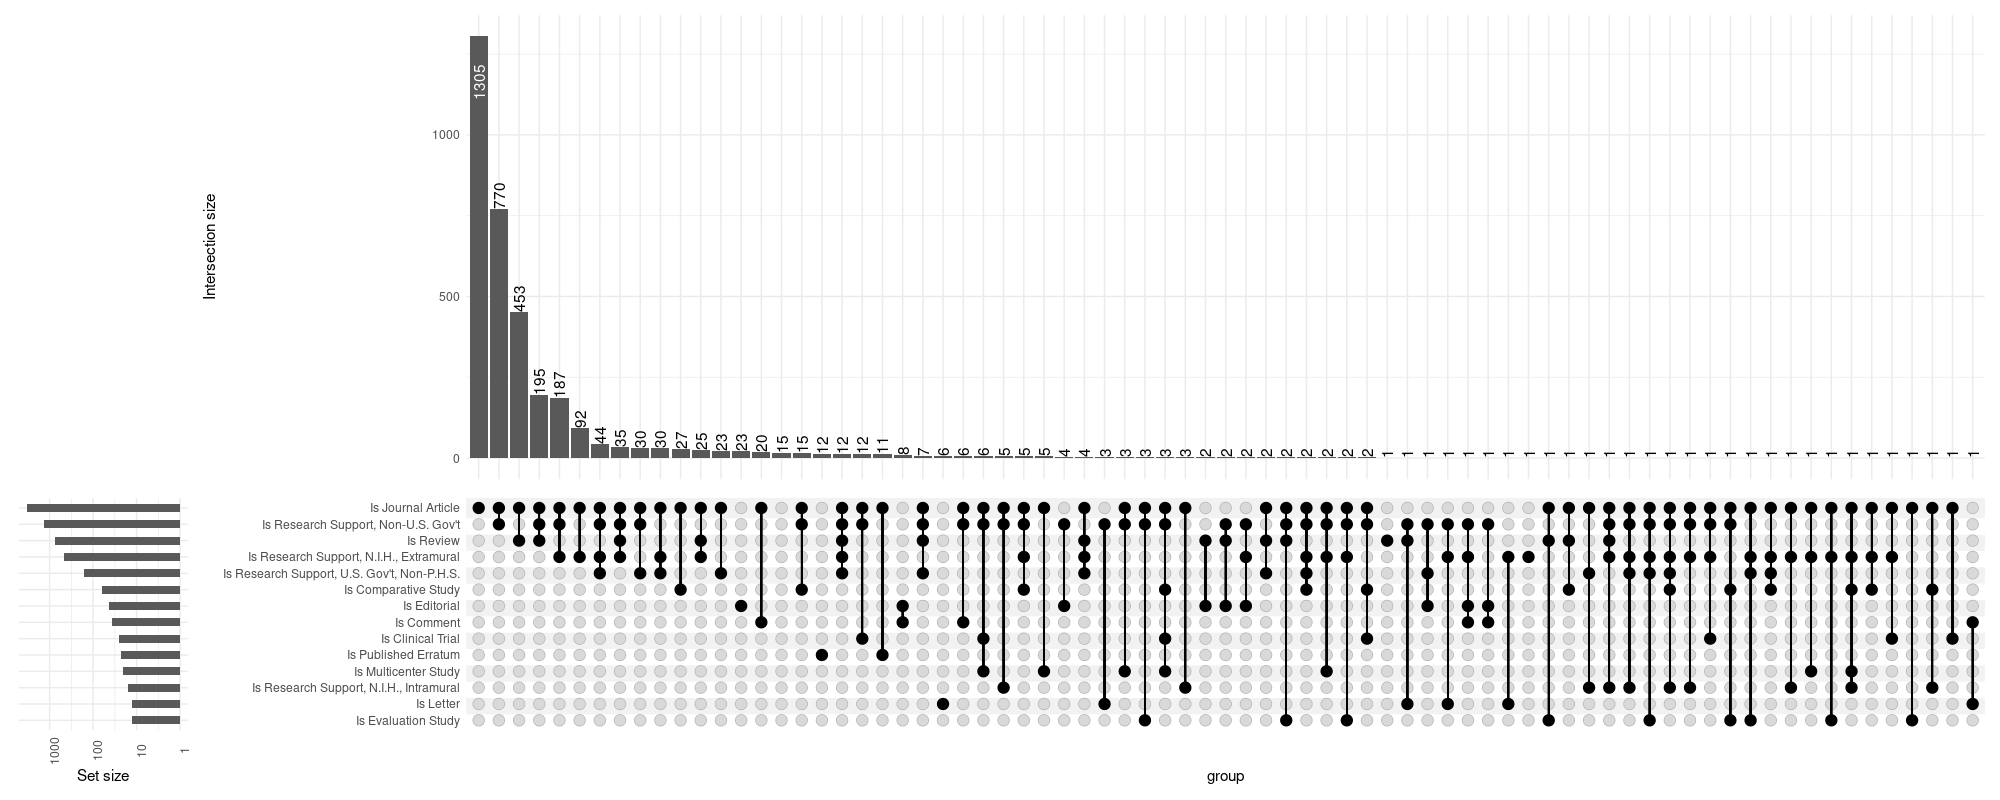

In [35]:
%%R -i publication_types_list -w 2000 -r 100 -h 800

upset(
    literature,
    publication_types_list,
    base_annotations=list(
        'Intersection size'=intersection_size(
            text=list(angle=90, vjust=0.5, hjust=0)
        )
    ),
    width_ratio=0.1,
    set_sizes=upset_set_size(
        width=0.5,
        layers=list(
            scale_y_continuous(trans=reverse_log_trans())
        )
    ),
    themes=upset_modify_themes(
        list('overall_sizes'=theme(axis.text.x=element_text(angle=90)))
    )
)

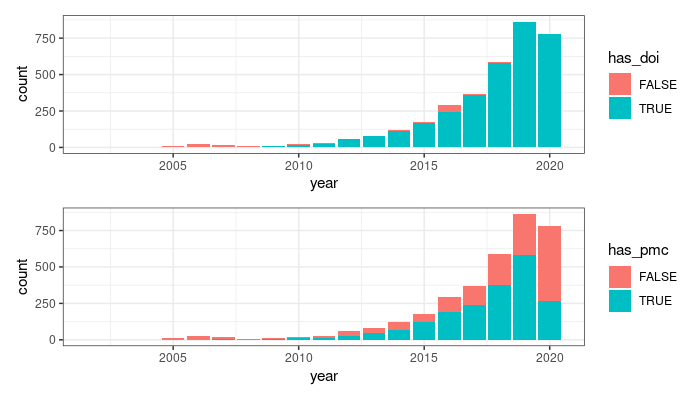

In [36]:
%%R -w 700 -h 400 -r 100
(
    ggplot(literature, aes(x=year, fill=has_doi))
    + geom_bar()
    + theme_bw()
) + (
    ggplot(literature, aes(x=year, fill=has_pmc))
    + geom_bar()
    + theme_bw()
) & plot_layout(ncol=1)

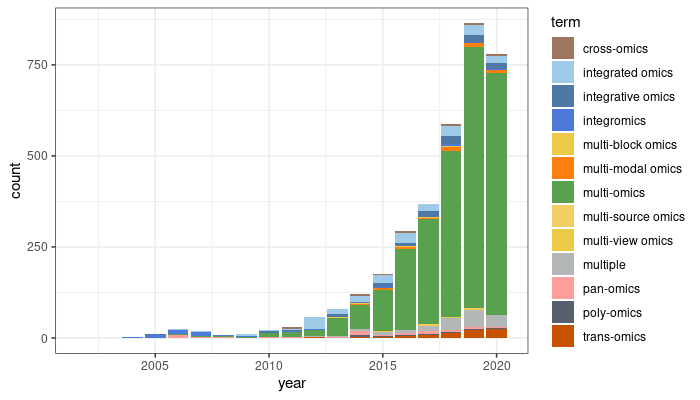

In [37]:
%%R -w 700 -h 400 -r 100
(
    ggplot(literature, aes(x=year, fill=term))
    + geom_bar()
    + scale_fill_manual(values=terms_colors)
    + theme_bw()
)

In [38]:
literature[literature[list(terms)].sum(axis=1) > 2][['title', 'doi', 'abstract_clean']]

,title,doi,abstract_clean
uid,,,
28624903,Early Diagnosis of Sepsis: Is an Integrated Om...,10.1007/s40291-017-0282-z,Sepsis remains one of the leading causes of de...
30006342,"Integrated Omics: Tools, Advances, and Future ...",10.1530/JME-18-0055,With the rapid adoption of high-throughput omi...
32186712,Adaptive multi-source multi-view latent featur...,10.1093/bib/bbaa028,Accumulating evidence has shown that microRNAs...
32675233,A mechanism-aware and multiomic machine-learni...,10.1073/pnas.2002959117,Metabolic modeling and machine learning are ke...


# Publication figures

In [39]:
%vault from pubmed_derived_data import predicted_article_types, reliable_article_types

Imported:

 - `predicted_article_types` (3D39430E)
 - `reliable_article_types` (5D584CB5)

at Tuesday, 04. Aug 2020 20:48

In [40]:
%vault from pubmed_derived_data import code_repositories

Imported `code_repositories` (5FF4AA2D) at Tuesday, 04. Aug 2020 20:48

In [41]:
from pandas import concat

In [42]:
combined_article_types = concat([
    predicted_article_types,
    reliable_article_types
]).loc[literature.index]

In [43]:
%vault from pubmed_derived_data import omics_features

Imported `omics_features` (32CBB0C4) at Tuesday, 04. Aug 2020 20:48

In [44]:
from helpers.text_processing import prefix_remover

In [45]:
omics_columns = omics_features.columns

omes_or_omics = (
    omics_features[omics_columns[omics_columns.str.startswith('ome_or_omic_')]]
    .rename(columns=prefix_remover('ome_or_omic_'))
)

In [46]:
literature['omic_terms_detected'] = omes_or_omics.sum(axis=1)

In [47]:
%vault from pubmed_derived_data import domain_features

Imported `domain_features` (9CBD2CED) at Tuesday, 04. Aug 2020 20:48

In [48]:
domain_features_py = (
    domain_features
    [domain_features.columns[domain_features.columns.str.startswith('mentioned_')]]
    .applymap(eval)
) 

In [49]:
data = (
    literature
    .drop(columns=['full_text', 'abstract'])
    .join(combined_article_types)
    .join(code_repositories)
    .join(omics_features)
    .join(
        domain_features
        [domain_features.columns[domain_features.columns.str.startswith('mentiones_')]]
    )
)
data['is_type_predicted'] = data.index.isin(predicted_article_types.index)

In [50]:
type_names = {
    'is_review': 'Review',
    'is_method': 'Computational method',
    'is_other_research_article': 'Other research article',
    'is_other': 'Other'
}

In [51]:
def get_type(t):
    if len(t) > 1:
        return 'multiple'
    if len(t):
        return type_names[list(t)[0]]
    return 'unknown'

In [52]:
data['chosen_type'] = combined_article_types.apply(lambda x: get_type(set(x[x != False].index)), axis=1)
data['chosen_type'].value_counts()

Other research article    2335
Review                     505
multiple                   205
Other                      145
unknown                    139
Computational method       126
Name: chosen_type, dtype: int64

In [53]:
%vault from journals_data import web_of_science_journals

Imported `web_of_science_journals` (E95CE31E) at Tuesday, 04. Aug 2020 20:48

In [54]:
from pandas import DataFrame

In [55]:
from statistics import mean
from helpers.stats import bootstrap

In [56]:
oo = []

for predicted in [True, False]:
    for type in combined_article_types.columns:
        d = data[(data[type] != False) & (data['is_type_predicted'] == predicted)].dropna(subset=['omic_terms_detected'])
        boot = bootstrap(list(d['omic_terms_detected']), stat=mean)
        oo.append({
            'is_type_predicted': predicted,
            'type': type_names[type],
            'mean_omics_detected': d['omic_terms_detected'].mean(),
            'mean_omics_detected_ci_lower': boot['lower'],
            'mean_omics_detected_ci_upper': boot['upper']
        })

oo = DataFrame(oo)

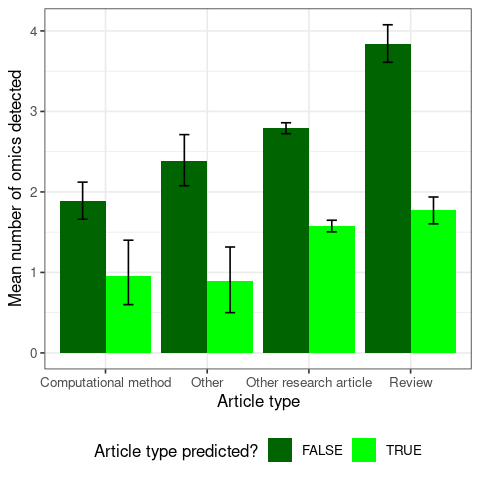

In [57]:
%%R -i oo -r 110
(
    ggplot(oo, aes(x=type, y=mean_omics_detected, fill=is_type_predicted))
    + geom_col(position='dodge')
    + geom_errorbar(
        aes(ymin=mean_omics_detected_ci_lower, ymax=mean_omics_detected_ci_upper),
        width=.2,
        position=position_dodge(width = 0.9)
    )
    + theme_bw()
    + scale_fill_manual(values=c('FALSE'='darkgreen', 'TRUE'='green'), name='Article type predicted?')
    + xlab('Article type')
    + ylab('Mean number of omics detected')
    + theme(legend.position = 'bottom')
)

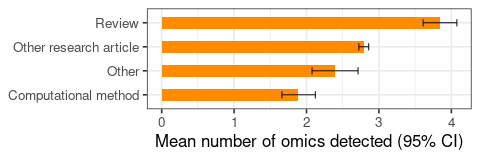

In [58]:
%%R -i oo -r 110 -h 160

plot_counts_summary =function(...) {(
    ggplot(oo[oo$is_type_predicted == FALSE, ], aes(x=type, y=mean_omics_detected))
    + geom_col(
        position='dodge', fill='darkorange',
        ...
    )
    + geom_errorbar(
        aes(ymin=mean_omics_detected_ci_lower, ymax=mean_omics_detected_ci_upper),
        width=.3,
        position=position_dodge(width=0.9),
        size=0.3
    )
    + theme_bw()
    + ylab('Mean number of omics detected (95% CI)')
    + theme(legend.position='bottom', axis.title.y=element_blank())
    + coord_flip()
)}
plot_counts_summary(width=0.5)

In [59]:
integ = 'integrated omics*'
multix = 'multi-view omics**'
other = 'other terms***'
data['term_group'] = data.term.replace({    
    'integrated omics': integ,
    'integrative omics': integ,
    'integromics': integ,
    'multi-block omics': multix,
    'multi-modal omics': multix,
    'multi-source omics': multix,
    'multi-view omics': multix,
    'cross-omics': other,
    'pan-omics': other,
    'poly-omics': other,
    'trans-omics': other,
    'multiple': 'multiple terms'
})

In [60]:
%R -i data

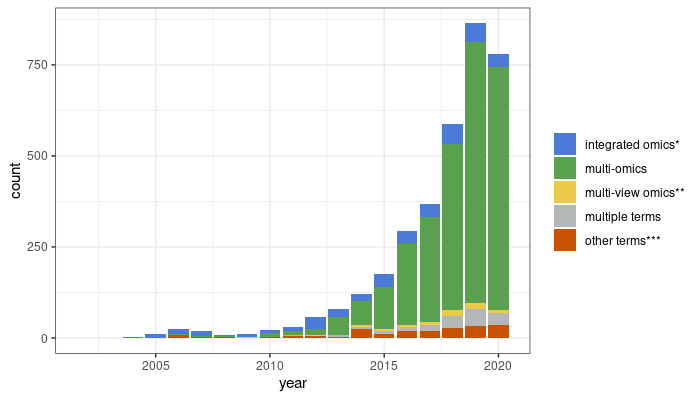

In [61]:
%%R -w 700 -h 400 -r 100 -i integ -i multix
terms_group_colors = c(
    terms_colors,
    c(
        'multi-omics'='#59A14F',
        'multi-view omics**'='#EDC948',
        'integrated omics*'='#4D79D7',
        'multiple terms'='#b3b7b8',
        'other terms***'='#c85200'
    )
)

term_counts = (
    ggplot(data, aes(x=year, fill=term_group))
    + geom_bar()
    + scale_fill_manual(values=terms_group_colors, name='')
    + theme(legend.position = 'bottom')
    + theme_bw()
)
term_counts

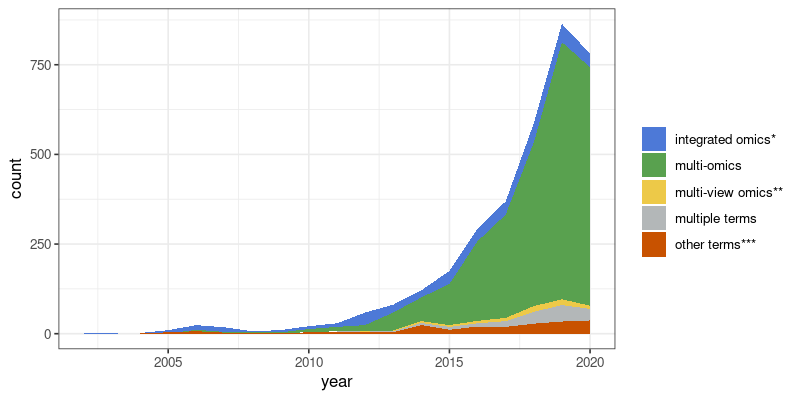

In [62]:
%%R -w 800 -h 400 -r 110

term_counts = (
    ggplot(data, aes(x=year, fill=term_group))
    + geom_area(stat='count')
    + scale_fill_manual(values=terms_group_colors, name='')
    + theme(legend.position = 'bottom')
    + theme_bw()
)
term_counts

In [63]:
%vault from pubmed_derived_data import all_articles_by_journal_and_year

Imported `all_articles_by_journal_and_year` (AB6E261E) at Tuesday, 04. Aug 2020 20:48

In [64]:
total_articles_in_popular_multi_omics_journals = all_articles_by_journal_and_year.groupby('year')['count'].sum()
total_articles_in_popular_multi_omics_journals.head(2)

year
2002    60303
2004    69921
Name: count, dtype: int64

In [65]:
term_groups_summary = data.assign(one=1).groupby(['year', 'term_group']).one.sum().rename('count').reset_index()
total_by_year = term_groups_summary.groupby('year')['count'].sum()

present = list(term_groups_summary[['term_group', 'year']].apply(tuple, axis=1))
for term in set(term_groups_summary.term_group):
    for year in set(term_groups_summary.year):
        if (term, year) not in present:
            term_groups_summary = term_groups_summary.append({
                'term_group': term,
                'year': year,
                'count': 0
            }, ignore_index=True)
term_groups_summary['count_adjusted'] = term_groups_summary['count'] / term_groups_summary.year.map(total_articles_in_popular_multi_omics_journals)
total_by_year.head(8)

year
2002.0     1
2004.0     2
2005.0    10
2006.0    24
2007.0    18
2008.0     7
2009.0    10
2010.0    21
Name: count, dtype: int64

In [66]:
start_with_year = total_by_year[total_by_year <= 3].idxmax() + 1
term_groups_summary = term_groups_summary[term_groups_summary.year >= start_with_year].copy()
start_with_year

2005.0

In [67]:
term_groups_summary['yearly_fraction'] = term_groups_summary['count'] / term_groups_summary.year.map(term_groups_summary.groupby('year')['count'].sum())

In [68]:
from datetime import date
SEARCH_DATE = date(year=2020, month=7, day=25)

In [69]:
term_groups_summary['complete_year'] = (term_groups_summary.year + 1).replace({2021: SEARCH_DATE.year + SEARCH_DATE.timetuple().tm_yday / 365})

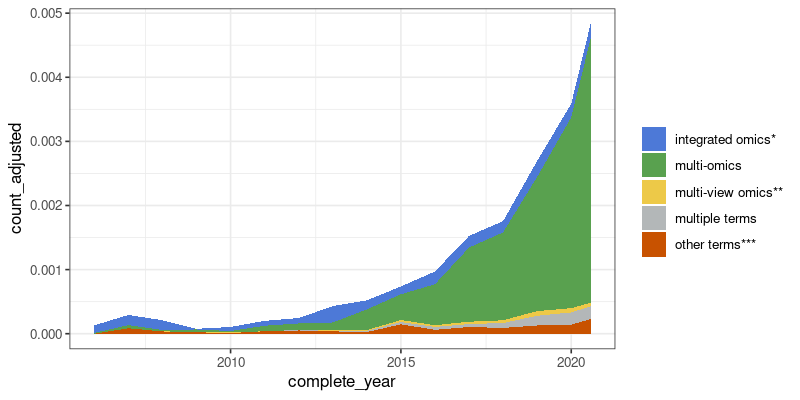

In [70]:
%%R -w 800 -h 400 -r 110 -i term_groups_summary

(
    ggplot(term_groups_summary, aes(x=complete_year, fill=term_group, y=count_adjusted))
    + geom_area(stat='identity')
    + scale_fill_manual(values=terms_group_colors, name='')
    + theme(legend.position = 'bottom')
    + theme_bw()
)

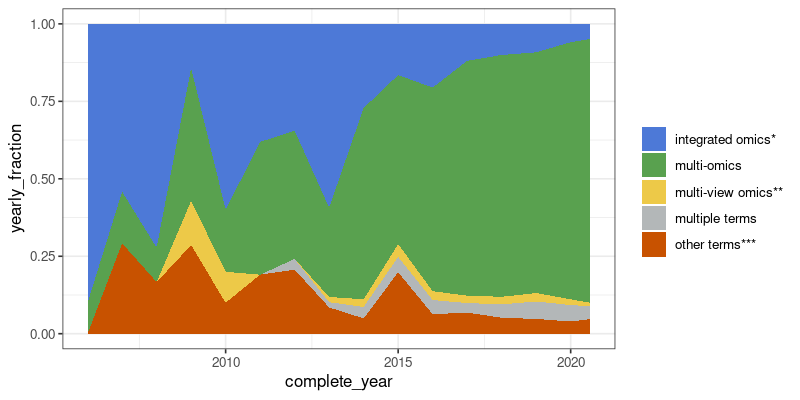

In [71]:
%%R -w 800 -h 400 -r 110 -i term_groups_summary

term_popularity = (
    ggplot(term_groups_summary, aes(x=complete_year, fill=term_group, y=yearly_fraction))
    + geom_area(stat='identity')
    + scale_fill_manual(values=terms_group_colors, name='')
    + theme(legend.position = 'bottom')
    + theme_bw()
)
term_popularity

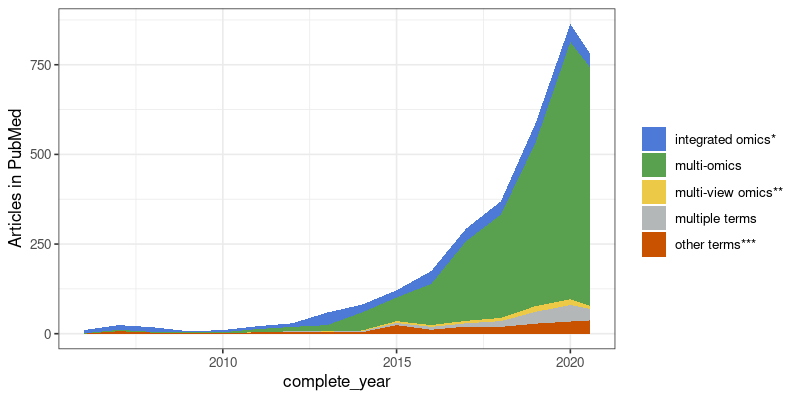

In [72]:
%%R -w 800 -h 400 -r 110 -i term_groups_summary

term_counts = ggplot(term_groups_summary, aes(x=complete_year, fill=term_group, y=count)) +
    geom_area(stat='identity') +
    scale_fill_manual(values=terms_group_colors, name='') +
    theme(legend.position = 'bottom') +
    theme_bw() +
    ylab('Articles in PubMed')
term_counts

In [73]:
from repository_detection import (
    source_code_platforms, mixed_publication_platforms, data_only_platforms,
    all_platforms as platforms
)

In [74]:
mostly_code_platforms = list(source_code_platforms) + ['bioconductor']
mostly_data_platforms = list(set(mixed_publication_platforms) - {'bioconductor'}) + list(data_only_platforms)

In [75]:
platform_id_to_name = {
    '.git': 'Other git',
    'bioconductor': 'Bioconductor',
    'bitbucket': 'Bitbucket',
    'cran': 'CRAN',
    'dryad': 'Dryad',
    'github': 'GitHub',
    'gitlab': 'GitLab',
    'osf': 'OSF',
    'pypi': 'PyPI',
    'sourceforge': 'SourceForge',
    'zenodo': 'Zenodo'
}

In [76]:
from pandas import Categorical

In [77]:
platforms_counts = code_repositories[[f'mentions_{platform}' for platform in platforms]].sum().to_frame('count').sort_values('count')
platforms_counts['platform_id'] = platforms_counts.index.str[len('mentions_'):]
platforms_counts['platform_type'] = platforms_counts.platform_id.apply(lambda p: 'code' if p in mostly_code_platforms else 'data')
platforms_counts.loc['mentions_zenodo', 'platform_type'] = 'both'
platforms_counts['platform_type'] = Categorical(platforms_counts['platform_type'], ordered=True, categories=['code', 'data', 'both'])
platforms_counts['platform_name'] = platforms_counts.platform_id.map(platform_id_to_name)
# platforms_counts['platform_name'] = Categorical(platforms_counts['platform_name'], ordered=True, categories=platforms_counts['platform_name'])
platforms_counts['platform_name'] = Categorical(platforms_counts['platform_name'], ordered=True, categories=reversed(platforms_counts['platform_name']))

In [78]:
platforms_counts['nudge_y'] = 0
platforms_counts.loc['mentions_gitlab', 'nudge_y'] = -0.5
platforms_counts.loc['mentions_osf', 'nudge_y'] = 0.5
platforms_counts['label_top'] = 0
for i, platform in enumerate(platforms_counts[platforms_counts['nudge_y'] == 0].index):
    platforms_counts.loc[platform, 'label_top'] = (((i % 2) - 0.5) * 2) * -1
platforms_counts

,count,platform_id,platform_type,platform_name,nudge_y,label_top
mentions_dryad,1,dryad,data,Dryad,0.0,1.0
mentions_gitlab,5,gitlab,code,GitLab,-0.5,0.0
mentions_osf,5,osf,data,OSF,0.5,0.0
mentions_pypi,7,pypi,code,PyPI,0.0,-1.0
mentions_zenodo,14,zenodo,both,Zenodo,0.0,1.0
mentions_bitbucket,17,bitbucket,code,Bitbucket,0.0,-1.0
mentions_sourceforge,46,sourceforge,code,SourceForge,0.0,1.0
mentions_.git,56,.git,code,Other git,0.0,-1.0
mentions_cran,82,cran,code,CRAN,0.0,1.0
mentions_bioconductor,116,bioconductor,code,Bioconductor,0.0,-1.0


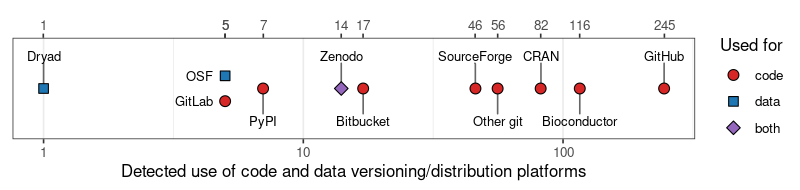

In [79]:
%%R -i platforms_counts -r 110 -w 800 -h 190

code_and_data_platforms = function(text_size=3, point_size=3, scale_name='Used for') {
    (
    ggplot(platforms_counts, aes(y=nudge_y, x=count))
    + geom_text(
        data=platforms_counts[platforms_counts$label_top == 0, ],
        aes(
            label=platform_name,
            x=count - 0.5
        ),
        hjust=1,
        size=text_size
    )
    + ggrepel::geom_text_repel(
        data=platforms_counts[platforms_counts$label_top != 0, ],
        aes(
            label=platform_name,
            nudge_y=label_top * 1.3
        ),
        min.segment.length=0,
        segment.curvature=-1e-20,
        segment.color='grey40',
        point.padding=2.5,
        size=text_size
    )
    + geom_point(
        aes(group=platform_name, fill=platform_type, shape=platform_type),
        color='black',
        size=point_size
    )
    + scale_fill_manual(
        values=c(
            'code'='#d62726',
            'data'='#1f77b4',
            'both'='#9467bd'
        ),
        name=scale_name
    )
    + scale_shape_manual(
        values=c(
            'code'='circle filled',
            'data'='square filled',
            'both'='diamond filled'
        ),
        name=scale_name
    )
    + theme_bw()
    + scale_x_log10(
        sec.axis = dup_axis(breaks=platforms_counts$count, name=element_blank()),
        name='Detected use of code and data versioning/distribution platforms'
    )
    #+ annotation_logticks(sides='b')
    + scale_y_continuous(expand=c(1, 0.5, 1, 0.5)) # bottom mult, bottom add, top mult, top add
    + theme(
        legend.position='right',
        axis.title.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.text.y=element_blank(),
        panel.grid.major.y=element_blank(),
        panel.grid.minor.y=element_blank(),
    )
    )
}

code_and_data_platforms()

In [80]:
20 / len(data) * 100

0.5788712011577424

In [81]:
def number_of_articles_mentioning_feature(features, exclude=[]):
    result = (
        Series(
            domain_features_py[list('mentioned_' + features + '_set')]
            .stack()
            .apply(list)
            .sum()
        )
        .value_counts()
        .drop(exclude)
        .to_frame('count')
        .rename_axis(index='term')
        .reset_index()
        .rename_axis(index='rank')
        .assign(kind=','.join(features))
    )
    result['ratio'] = result['count'] / sum(result['count'])
    return result

In [82]:
from pandas import concat
top_n = 10
features_counts = concat([
    number_of_articles_mentioning_feature(
        Series(['diseases', 'clinical_findings']),
        exclude=['disease']
    ).head(top_n),
    number_of_articles_mentioning_feature(
        Series(['species'])
    ).head(top_n)
]).reset_index()
features_counts.head(2)

,rank,term,count,kind,ratio
0,0,cancer,786,"diseases,clinical_findings",0.234627
1,1,carcinoma,132,"diseases,clinical_findings",0.039403


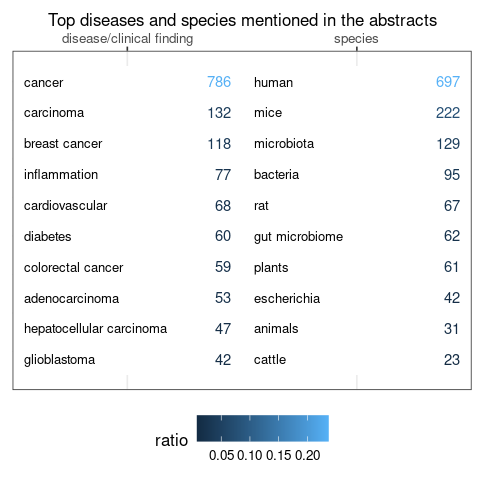

In [83]:
%%R -i features_counts -r 110
plot_features = function(names_padding=0.05, counts_padding=0.05, expand=expansion(mult=0, add=0)) {
    (
    ggplot(features_counts, aes(x=kind, y=rank))
    + geom_tile(fill='white')
    + geom_text(aes(label=strtrim(term, 25)), hjust=0, position=position_nudge(x=-(0.5-names_padding)), size=3)
    + geom_text(
        aes(label=count, color=ratio),
        hjust=1, position=position_nudge(x=0.5-counts_padding), size=3.4
    )
    + theme_bw()
    + scale_y_reverse()
    + scale_x_discrete(
        position="top",
        labels=c(
            'diseases,clinical_findings'='disease/clinical finding',
            'species'='species'
        ),
        name='Top diseases and species mentioned in the abstracts',
        expand=expand
    )
    + theme(
        legend.position='bottom',
        axis.title.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.text.y=element_blank(),
    )
)}
plot_features(names_padding=0.05, counts_padding=0.05)

In [84]:
from omics import omics_by_entity, omics_by_entity_group

In [85]:
omic_entities_columns = Series(list(omics_by_entity.keys()))
omic_entities_group_columns = Series(list(omics_by_entity_group.keys()))
omic_entities = data.rename(columns=prefix_remover('entity_', enforce=False))
omic_entities_groups = data.rename(columns=prefix_remover('entity_group_', enforce=False))
%R -i omic_entities
%R -i omic_entities_groups

[1] "Dropping empty groups: clades (meta_* & pan_*), protein modifications, exogenous factors, clinical data"


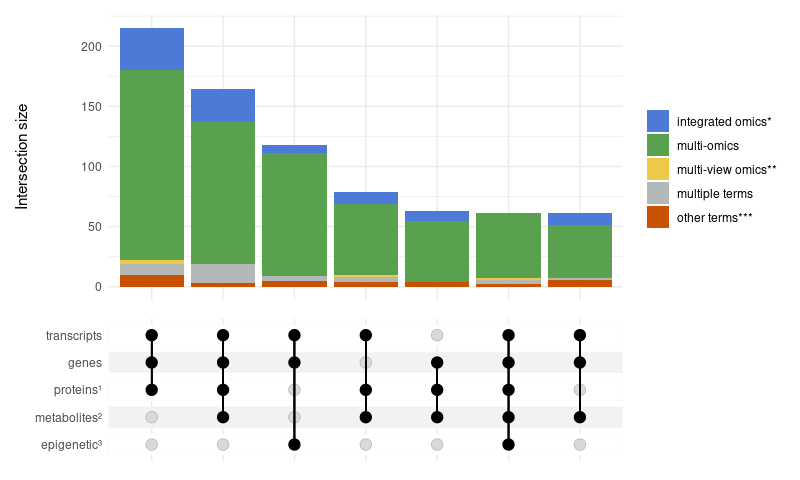

In [86]:
%%R -w 800 -r 100 -i omic_entities_columns

omics_upset = function(...) {
    upset(
        omic_entities,
        omic_entities_columns,
        min_size=50,
        width_ratio=0.2,
        min_degree=2,
        base_annotations=list(
            'Intersection size'=intersection_size(
                counts=FALSE,
                aes=aes(fill=term_group)
            )
        ),
        themes=upset_modify_themes(
            list(
                'overall_sizes'=theme(axis.text.x=element_text(angle=90))
            )
        ),
        labeller=function(x) {
            c(
                'endogenous molecules'='metabolites²',
                'genes'='genes',
                'transcripts'='transcripts',
                'proteins & peptides'='proteins¹',
                'epigenetic modifications'='epigenetic³'
            )[x]
        },
        set_sizes=FALSE,
        ...
    ) + theme(axis.title.x=element_blank()) & scale_fill_manual(values=terms_group_colors, name='')
}
omics_upset()

In [87]:
%%R -r 110 -w 800 -h 800

upset_plot = wrap_elements(
    omics_upset(dot_size=1.75)
    & theme(
        legend.position='none',
        plot.margin=unit(c(0, 0, -0.3, 0), "cm"),
        panel.background=element_rect(fill='transparent', colour=NA),
        plot.background=element_rect(fill='transparent', colour=NA)
    )
    + theme(panel.border=element_rect(color='grey20', fill=NA))
)

TITLE_SIZE = 10
common_theme = theme(
    axis.title.x=element_blank(),
    plot.title=element_text(size=TITLE_SIZE)
)

[1] "Dropping empty groups: clades (meta_* & pan_*), protein modifications, exogenous factors, clinical data"


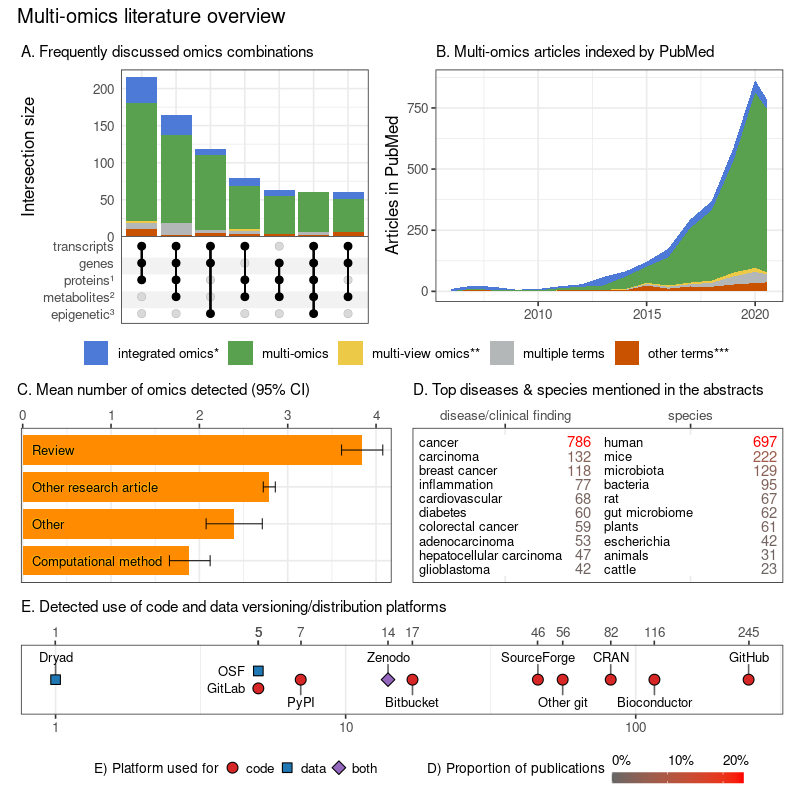

In [88]:
%%R -r 110 -w 800 -h 800
(
    (
        (
            (
                (
                    upset_plot
                    + labs(
                        title='A. Frequently discussed omics combinations'
                    )
                    + common_theme
                )
                |
                (
                    term_counts
                    + common_theme
                    + labs(
                        title='B. Multi-omics articles indexed by PubMed'
                    )
                )
            )
            & theme(legend.position='bottom')
            & plot_layout(guides='collect')
        )
        /
        (
            (
                plot_counts_summary(width=0.8)
                + scale_y_continuous(
                    expand=c(0, 0.02, 0, 0.1),
                    position='right',
                )
                + shadowtext::geom_shadowtext(
                    aes(label=type, y=0.1), hjust=0, size=3,
                    bg.r=0.05, color='black', bg.color='orange'
                )
                + theme(
                    legend.position='right',
                    axis.title.y=element_blank(),
                    axis.ticks.y=element_blank(),
                    axis.text.y=element_blank(),
                    axis.title.x=element_blank(),
                    plot.title.position='plot'
                )
                + common_theme
                + labs(title='C. Mean number of omics detected (95% CI)')
            )
            |
            (
                plot_features(names_padding=0.035, counts_padding=0.035, expand=expansion(add=0.0))
                + guides(
                    color=guide_colorbar(
                        barheight=0.5,
                        label.position='top',
                        title.vjust=0.5,
                        title.theme=element_text(size=9),
                        order=0,
                        #label.vjust=-5,
                        label.hjust=0
                    )
                )
                + common_theme
                + scale_color_gradient(
                    low='grey40',
                    high='red',
                    name='D) Proportion of publications',
                    breaks=c(0.0, 0.1, 0.2),
                    limits=function(automatic_limits) {
                        automatic_limits[[1]] = 0
                        automatic_limits
                    },
                    labels=scales::percent
                )
                + labs(
                    title='D. Top diseases & species mentioned in the abstracts'
                )
            ) & theme(legend.position='bottom')
        )
        /
        (
            code_and_data_platforms(scale_name='E) Platform used for')
            + common_theme
            + labs(
                title='E. Detected use of code and data versioning/distribution platforms'
            )
            + guides(
                fill=guide_legend(
                    keywidth=0.1,
                    title.theme=element_text(size=9),
                )
            )
        ) & theme(
            legend.position='bottom',
            legend.box='horizontal',
            legend.direction='horizontal',
            legend.margin=unit(-15, 'cm'),
        )
    )
    + plot_layout(
        heights=c(3, 2, 0.9),
        guides='collect'
    )
    + plot_annotation(
      title='Multi-omics literature overview',
    )
)

In [89]:
data.has_full_text.mean()

0.779087647360328

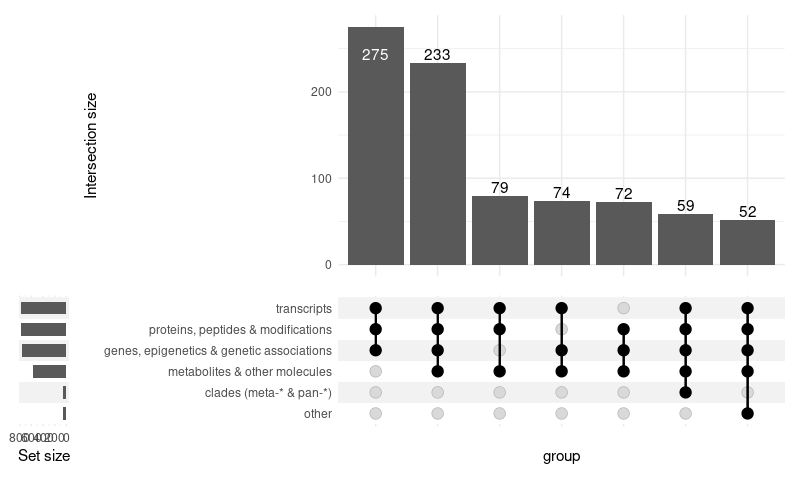

In [90]:
%%R -w 800 -r 100 -i omic_entities_group_columns

upset(omic_entities_groups, omic_entities_group_columns, min_size=50, width_ratio=0.1, min_degree=2)

[1] "Dropping empty groups: clades (meta_* & pan_*), protein modifications, exogenous factors, clinical data"


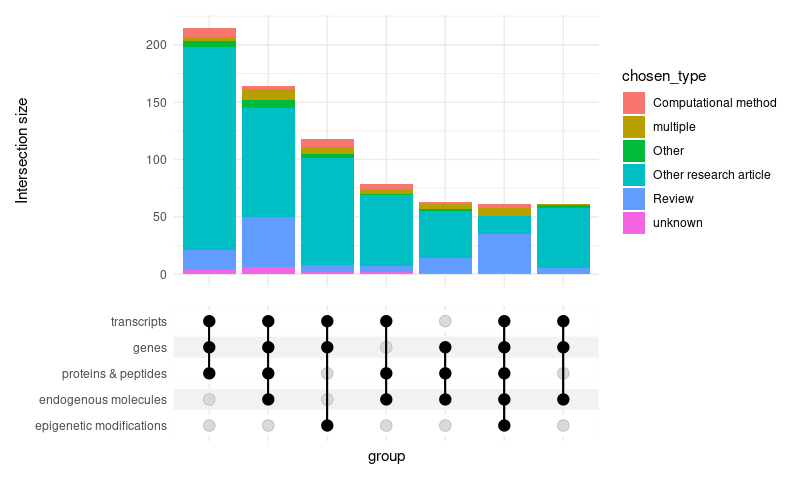

In [91]:
%%R -w 800 -r 100 -i omic_entities_columns

upset(
    omic_entities,
    omic_entities_columns,
    min_size=50,
    width_ratio=0.2,
    min_degree=2,
    base_annotations=list(
        'Intersection size'=intersection_size(
            counts=FALSE,
            aes=aes(fill=chosen_type)
        )
    ),
    themes=upset_modify_themes(
        list(
            'overall_sizes'=theme(axis.text.x=element_text(angle=90))
        )
    ),
    set_sizes=FALSE
)# & scale_fill_manual(values=terms_group_colors, name='')